In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
from torch import nn
from torch import optim
import os

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def carregar_dados(train_data,test_data):
  train_data = pd.read_csv(train_data)
  val_data = pd.read_csv(test_data)

  X_train = train_data.drop(['hysteresis', 'joule'], axis=1)
  y_train = train_data[['hysteresis', 'joule']]

  X_val = val_data.drop(['hysteresis', 'joule'], axis=1)
  y_val = val_data[['hysteresis', 'joule']]

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_val_scaled = scaler.transform(X_val)

  X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

  X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
  y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

  return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor

def carregar_dadosv2(train_data, test_data, test_size=0.2, random_state=42):
    # Load data from CSV file
    train_data = pd.read_csv(train_data)
    val_data = pd.read_csv(test_data)

    # Split data into features (X) and targets (y)
    X = train_data.drop(['hysteresis', 'joule'], axis=1)
    y = train_data[['hysteresis', 'joule']]

    # Perform train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_test = val_data.drop(['hysteresis', 'joule'], axis=1)
    y_test = val_data[['hysteresis', 'joule']]

    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor

In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_comparacao(y_true, y_pred):
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()

    plt.figure(figsize=(8, 6))

    plt.scatter(y_true, y_pred, color='blue', alpha=0.5)

    max_val = max(y_true.max(), y_pred.max())
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Linha de Referência')

    plt.xlabel('Valores previstos')
    plt.ylabel('valores Reais')
    plt.title('Comparação entre Valores Reais e Valores Previstos')
    plt.legend()


    plt.show()


import matplotlib.pyplot as plt

In [ ]:
class tenlayersNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(tenlayersNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, 256)
        self.fc7 = nn.Linear(256, 256)
        self.fc8 = nn.Linear(256, 256)
        self.fc9 = nn.Linear(256, 4)
        self.fc10 = nn.Linear(4, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = self.relu(self.fc8(x))
        x = self.relu(self.fc9(x))
        x = self.fc10(x)
        return x


In [ ]:

def load_model(filename, model_class, input_size, output_size):
    print("Carregando modelo...")
    checkpoint = torch.load(filename)

    model = model_class(input_size, output_size)

    model.load_state_dict(checkpoint['state_dict'])

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    optimizer.load_state_dict(checkpoint['optimizer'])

    return model, optimizer

def save_model(state,filename="Saved_Model.pth"):
  print("salvando modelo...")
  torch.save(state,filename)

def train(model,num_epochs,optimizer):
  criterion = nn.MSELoss()
  for epoch in range(num_epochs):
      optimizer.zero_grad()
      outputs = model(X_train_tensor)
      loss = criterion(outputs, y_train_tensor)
      loss.backward()
      optimizer.step()

      if (epoch+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

      model.eval()  # Set the model to evaluation mode
      with torch.no_grad():  # Disable gradient calculation for validation
          val_outputs = model(X_val_tensor)
          val_loss = criterion(val_outputs, y_val_tensor)
def test(model,data):
  model.eval()
  criterion = nn.MSELoss()
  with torch.no_grad():
      predicted = model(data[0])
      test_loss = criterion(predicted, data[1])
      print(f'Test Loss: {test_loss.item():.4f}')
  return predicted





In [ ]:
def fine_tune(model, train_data, val_data, num_epochs=10, learning_rate=0.001, freeze_layers=8):

    layers_to_freeze = [
        model.fc1, model.fc2, model.fc3, model.fc4,
        model.fc5, model.fc6, model.fc7, model.fc8
    ][:freeze_layers]

    for layer in layers_to_freeze:
        for param in layer.parameters():
            param.requires_grad = False

    criterion = nn.MSELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

    train_loader = DataLoader(TensorDataset(train_data[0], train_data[1]), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_data[0], val_data[1]), batch_size=32, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')


In [ ]:
folder_path = '/content/drive/MyDrive/FederatedLearning-main/Data/IPMSM_datasets/dataset_for_iron_losses_of_IPMSMs/2D'
os.chdir(folder_path)

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = carregar_dadosv2('dados_de_treino.csv','dados_de_teste.csv')
input_size = X_train_tensor.shape[1]
print(input_size)
output_size = y_train_tensor.shape[1]
print(output_size)
model2D = tenlayersNetwork(input_size, output_size)
optimizer = optim.Adam(model2D.parameters(), lr=0.001)

14
2


In [ ]:
train(model2D,1000,optimizer)

modeltosave = {'state_dict': model2D.state_dict(),'optimizer':optimizer.state_dict()}
save_model(modeltosave)

Epoch [100/1000], Loss: 0.2512
Epoch [200/1000], Loss: 0.1519
Epoch [300/1000], Loss: 0.0086
Epoch [400/1000], Loss: 0.0026
Epoch [500/1000], Loss: 0.0022
Epoch [600/1000], Loss: 0.0028
Epoch [700/1000], Loss: 0.0014
Epoch [800/1000], Loss: 0.0012
Epoch [900/1000], Loss: 0.0009
Epoch [1000/1000], Loss: 0.0008
salvando modelo...


Test Loss: 0.0013


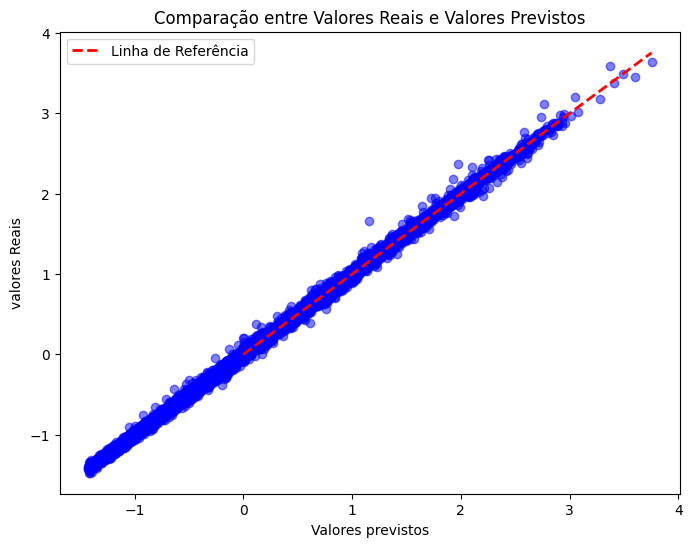

In [ ]:
plot_comparacao(y_val_tensor,test(model2D,[X_val_tensor,y_val_tensor]))

Test Loss: 0.1039


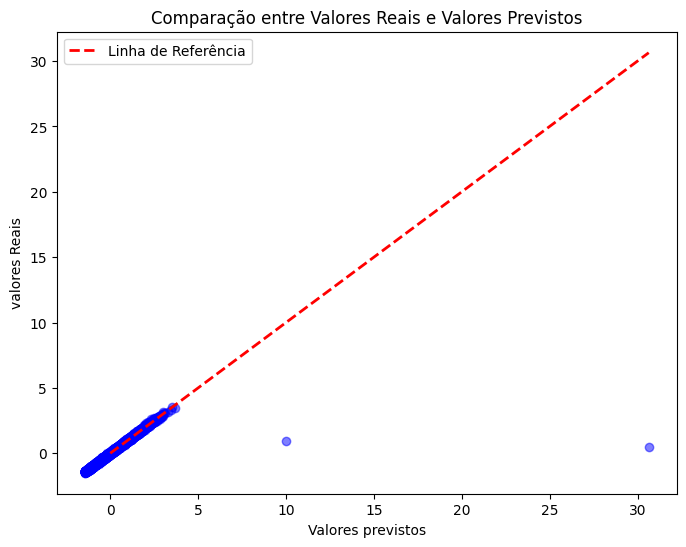

In [ ]:
plot_comparacao(y_test_tensor,test(model2D,[X_test_tensor,y_test_tensor]))

In [ ]:
new_model2dnabla, new_optimizer2d = load_model("Saved_Model.pth", tenlayersNetwork,input_size,output_size)
new_model2dV, new_optimizerV = load_model("Saved_Model.pth", tenlayersNetwork,input_size,output_size)

Carregando modelo...
Carregando modelo...


In [ ]:
folder_path = '/content/drive/MyDrive/FederatedLearning-main/Data/IPMSM_datasets/dataset_for_iron_losses_of_IPMSMs/Nabla'
os.chdir(folder_path)

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = carregar_dadosv2('dados_de_treino.csv','dados_de_teste.csv')
input_size = X_train_tensor.shape[1]
output_size = y_train_tensor.shape[1]

Test Loss: 1.3773


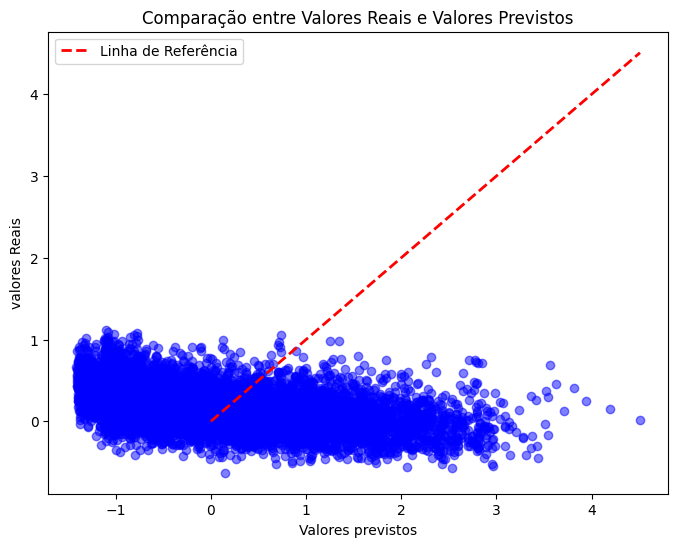

In [ ]:
new_model2dnabla.fc1 = nn.Linear(input_size, 256)
plot_comparacao(y_val_tensor,test(new_model2dnabla,[X_val_tensor,y_val_tensor]))

In [ ]:
fine_tune(new_model2dnabla,[X_train_tensor,y_train_tensor],[X_val_tensor,y_val_tensor],freeze_layers=0,num_epochs=50)

Epoch 1/50, Training Loss: 0.04974230991408513, Validation Loss: 0.026105096112487132
Epoch 2/50, Training Loss: 0.014299200344959878, Validation Loss: 0.016606224060122823
Epoch 3/50, Training Loss: 0.012893363522314039, Validation Loss: 0.012635367194286965
Epoch 4/50, Training Loss: 0.009533577671264858, Validation Loss: 0.01204952615602263
Epoch 5/50, Training Loss: 0.009372061884564959, Validation Loss: 0.021761293041295017
Epoch 6/50, Training Loss: 0.008499844455720286, Validation Loss: 0.00922450960999162
Epoch 7/50, Training Loss: 0.007991735364651014, Validation Loss: 0.009049524005566691
Epoch 8/50, Training Loss: 0.007640761972939276, Validation Loss: 0.009867208386803496
Epoch 9/50, Training Loss: 0.007140954138276908, Validation Loss: 0.00919188109130181
Epoch 10/50, Training Loss: 0.006567688612025263, Validation Loss: 0.013310731195941054
Epoch 11/50, Training Loss: 0.007324145749119309, Validation Loss: 0.006544195209902808
Epoch 12/50, Training Loss: 0.005435273724130

Test Loss: 0.0075


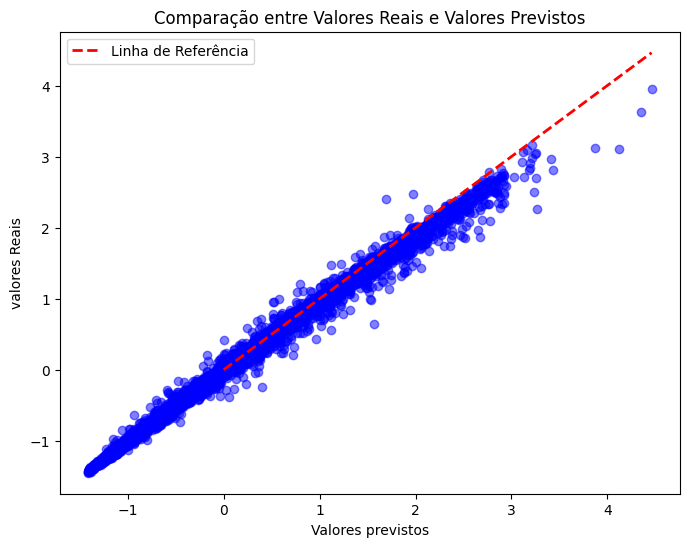

In [ ]:
plot_comparacao(y_test_tensor,test(new_model2dnabla,[X_test_tensor,y_test_tensor]))

In [ ]:
folder_path = '/content/drive/MyDrive/FederatedLearning-main/Data/IPMSM_datasets/dataset_for_iron_losses_of_IPMSMs (1)/dataset_for_iron_losses_of_IPMSMs/V'
os.chdir(folder_path)

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor = carregar_dados('dados_de_treino.csv','dados_de_teste.csv')
input_size = X_train_tensor.shape[1]
output_size = y_train_tensor.shape[1]

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/FederatedLearning-main/Data/IPMSM_datasets/dataset_for_iron_losses_of_IPMSMs (1)/dataset_for_iron_losses_of_IPMSMs/V'

In [ ]:
new_model2dV.fc1 = nn.Linear(input_size, 1024)
plot_comparacao(y_val_tensor,test(new_model2dV))